#**Importing Required Libraries**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("ticks")
sns.set_context("poster");
import plotly.express as px
from scipy.stats import norm
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
import calendar
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import  LabelEncoder
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
from lightgbm import LGBMRegressor
import lightgbm
from xgboost import XGBRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error
pd.options.display.max_rows = 50
pd.options.display.float_format = "{:.3f}".format
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Loading Data**


In [4]:
b_data = pd.read_csv("data.csv", encoding ="ISO-8859-1")

#**Studying Data**

In [5]:
b_data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.200,37,2.200,2000,-17.600,0.000,0.000,0.000,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.500,38,0.800,2000,-17.600,0.000,0.000,0.000,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.000,39,1.000,2000,-17.700,0.000,0.000,0.000,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.200,40,0.900,2000,-17.600,0.000,0.000,0.000,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.000,36,2.300,2000,-18.600,0.000,0.000,0.000,Winter,No Holiday,Yes


In [6]:
b_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.000,704.602,644.997,0.000,191.000,504.500,1065.250,3556.000
Hour,8760.000,11.500,6.923,0.000,5.750,11.500,17.250,23.000
Temperature(°C),8760.000,12.883,11.945,-17.800,3.500,13.700,22.500,39.400
Humidity(%),8760.000,58.226,20.362,0.000,42.000,57.000,74.000,98.000
Wind speed (m/s),8760.000,1.725,1.036,0.000,0.900,1.500,2.300,7.400
Visibility (10m),8760.000,1436.826,608.299,27.000,940.000,1698.000,2000.000,2000.000
Dew point temperature(°C),8760.000,4.074,13.060,-30.600,-4.700,5.100,14.800,27.200
Solar Radiation (MJ/m2),8760.000,0.569,0.869,0.000,0.000,0.010,0.930,3.520
Rainfall(mm),8760.000,0.149,1.128,0.000,0.000,0.000,0.000,35.000
Snowfall (cm),8760.000,0.075,0.437,0.000,0.000,0.000,0.000,8.800


In [7]:
b_data.rename({"Temperature(°C)": "Temperature",
               "Functioning Day":"Functioning_Day",
                "Humidity(%)": "Humidity",
                "Wind speed (m/s)": "Wind_speed",
                "Visibility (10m)": "Visibility",
                "Dew point temperature(°C)": "Dew_point_temperature",
                "Solar Radiation (MJ/m2)": "Solar_Radiation",
                "Snowfall (cm)": "Snowfall",
                "Rainfall(mm)": "Rainfall",
                "Rented Bike Count": "Rented_Bike_Count"},
                axis = "columns", inplace = True)

In [8]:
b_data.isnull().sum()

,0
Date,0
Rented_Bike_Count,0
Hour,0
Temperature,0
Humidity,0
Wind_speed,0
Visibility,0
Dew_point_temperature,0
Solar_Radiation,0
Rainfall,0


In [9]:
b_data.duplicated().value_counts()

,count
False,8760


In [10]:
df = b_data.copy()

In [12]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, dayfirst=True)

In [13]:
df['month'] = pd.DatetimeIndex(df['Date']).month
df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])

df['day'] = df['Date'].dt.day_name()

df['year'] = df['Date'].dt.year

df.head(1)

,Date,Rented_Bike_Count,Hour,Temperature,Humidity,Wind_speed,Visibility,Dew_point_temperature,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day,month,day,year
0,2017-12-01,254,0,-5.200,37,2.200,2000,-17.600,0.000,0.000,0.000,Winter,No Holiday,Yes,Dec,Friday,2017


In [14]:
def total(df,var):
  total = len(df[var].value_counts())
  return total

In [15]:
total_lenght_different_column = {
    'Seasons': total(df,'Seasons'),
    'Holiday': total(df,'Holiday'),
    'Funtioning_Day': total(df,'Functioning_Day'),
    'month' : total(df,'month'),
    'day'   : total(df,'day'),
    'year'  : total(df,'year')
}

In [16]:
total_df = pd.DataFrame.from_dict(total_lenght_different_column,orient='index')

In [17]:
df.drop(columns=['Date'],inplace=True)
df.head(1)

,Rented_Bike_Count,Hour,Temperature,Humidity,Wind_speed,Visibility,Dew_point_temperature,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day,month,day,year
0,254,0,-5.200,37,2.200,2000,-17.600,0.000,0.000,0.000,Winter,No Holiday,Yes,Dec,Friday,2017


In [18]:
df['Hour']=df['Hour'].astype('object')

In [19]:
total_df.T

,Seasons,Holiday,Funtioning_Day,month,day,year
0,4,2,2,12,7,2


In [20]:
df['year'] = df['year'].astype('object')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rented_Bike_Count      8760 non-null   int64  
 1   Hour                   8760 non-null   object 
 2   Temperature            8760 non-null   float64
 3   Humidity               8760 non-null   int64  
 4   Wind_speed             8760 non-null   float64
 5   Visibility             8760 non-null   int64  
 6   Dew_point_temperature  8760 non-null   float64
 7   Solar_Radiation        8760 non-null   float64
 8   Rainfall               8760 non-null   float64
 9   Snowfall               8760 non-null   float64
 10  Seasons                8760 non-null   object 
 11  Holiday                8760 non-null   object 
 12  Functioning_Day        8760 non-null   object 
 13  month                  8760 non-null   object 
 14  day                    8760 non-null   object 
 15  year

# **Exploratory Data Analysis**


In [22]:
dfr = df.copy()

In [23]:
num_feature = dfr.select_dtypes(exclude='object')
print(f'Numerical feature : {num_feature.columns.to_list()}')

Numerical feature : ['Rented_Bike_Count', 'Temperature', 'Humidity', 'Wind_speed', 'Visibility', 'Dew_point_temperature', 'Solar_Radiation', 'Rainfall', 'Snowfall']


In [24]:
cat_feature = dfr.loc[:,  ~dfr.columns.isin(num_feature.columns.to_list())]
print(f'Categorical feature : {cat_feature.columns.to_list()}')

Categorical feature : ['Hour', 'Seasons', 'Holiday', 'Functioning_Day', 'month', 'day', 'year']


In [25]:
def density_plot(dfr,num_feature):
  graph = plt.figure(figsize = (20,30))
  for i,col in enumerate(num_feature) :
    sns.set_context('poster');
    plt.subplot(6,2,i+1);
    sns.distplot(dfr[col], color = '#055E85', fit = norm);
    feature = dfr[col]
    plt.axvline(feature.mean(), color='#ff033e', linestyle='dashed', linewidth=3,label= 'mean');
    plt.axvline(feature.median(), color='#A020F0', linestyle='dashed', linewidth=3,label='median');
    plt.title(f'{col.title()}');
    plt.tight_layout();

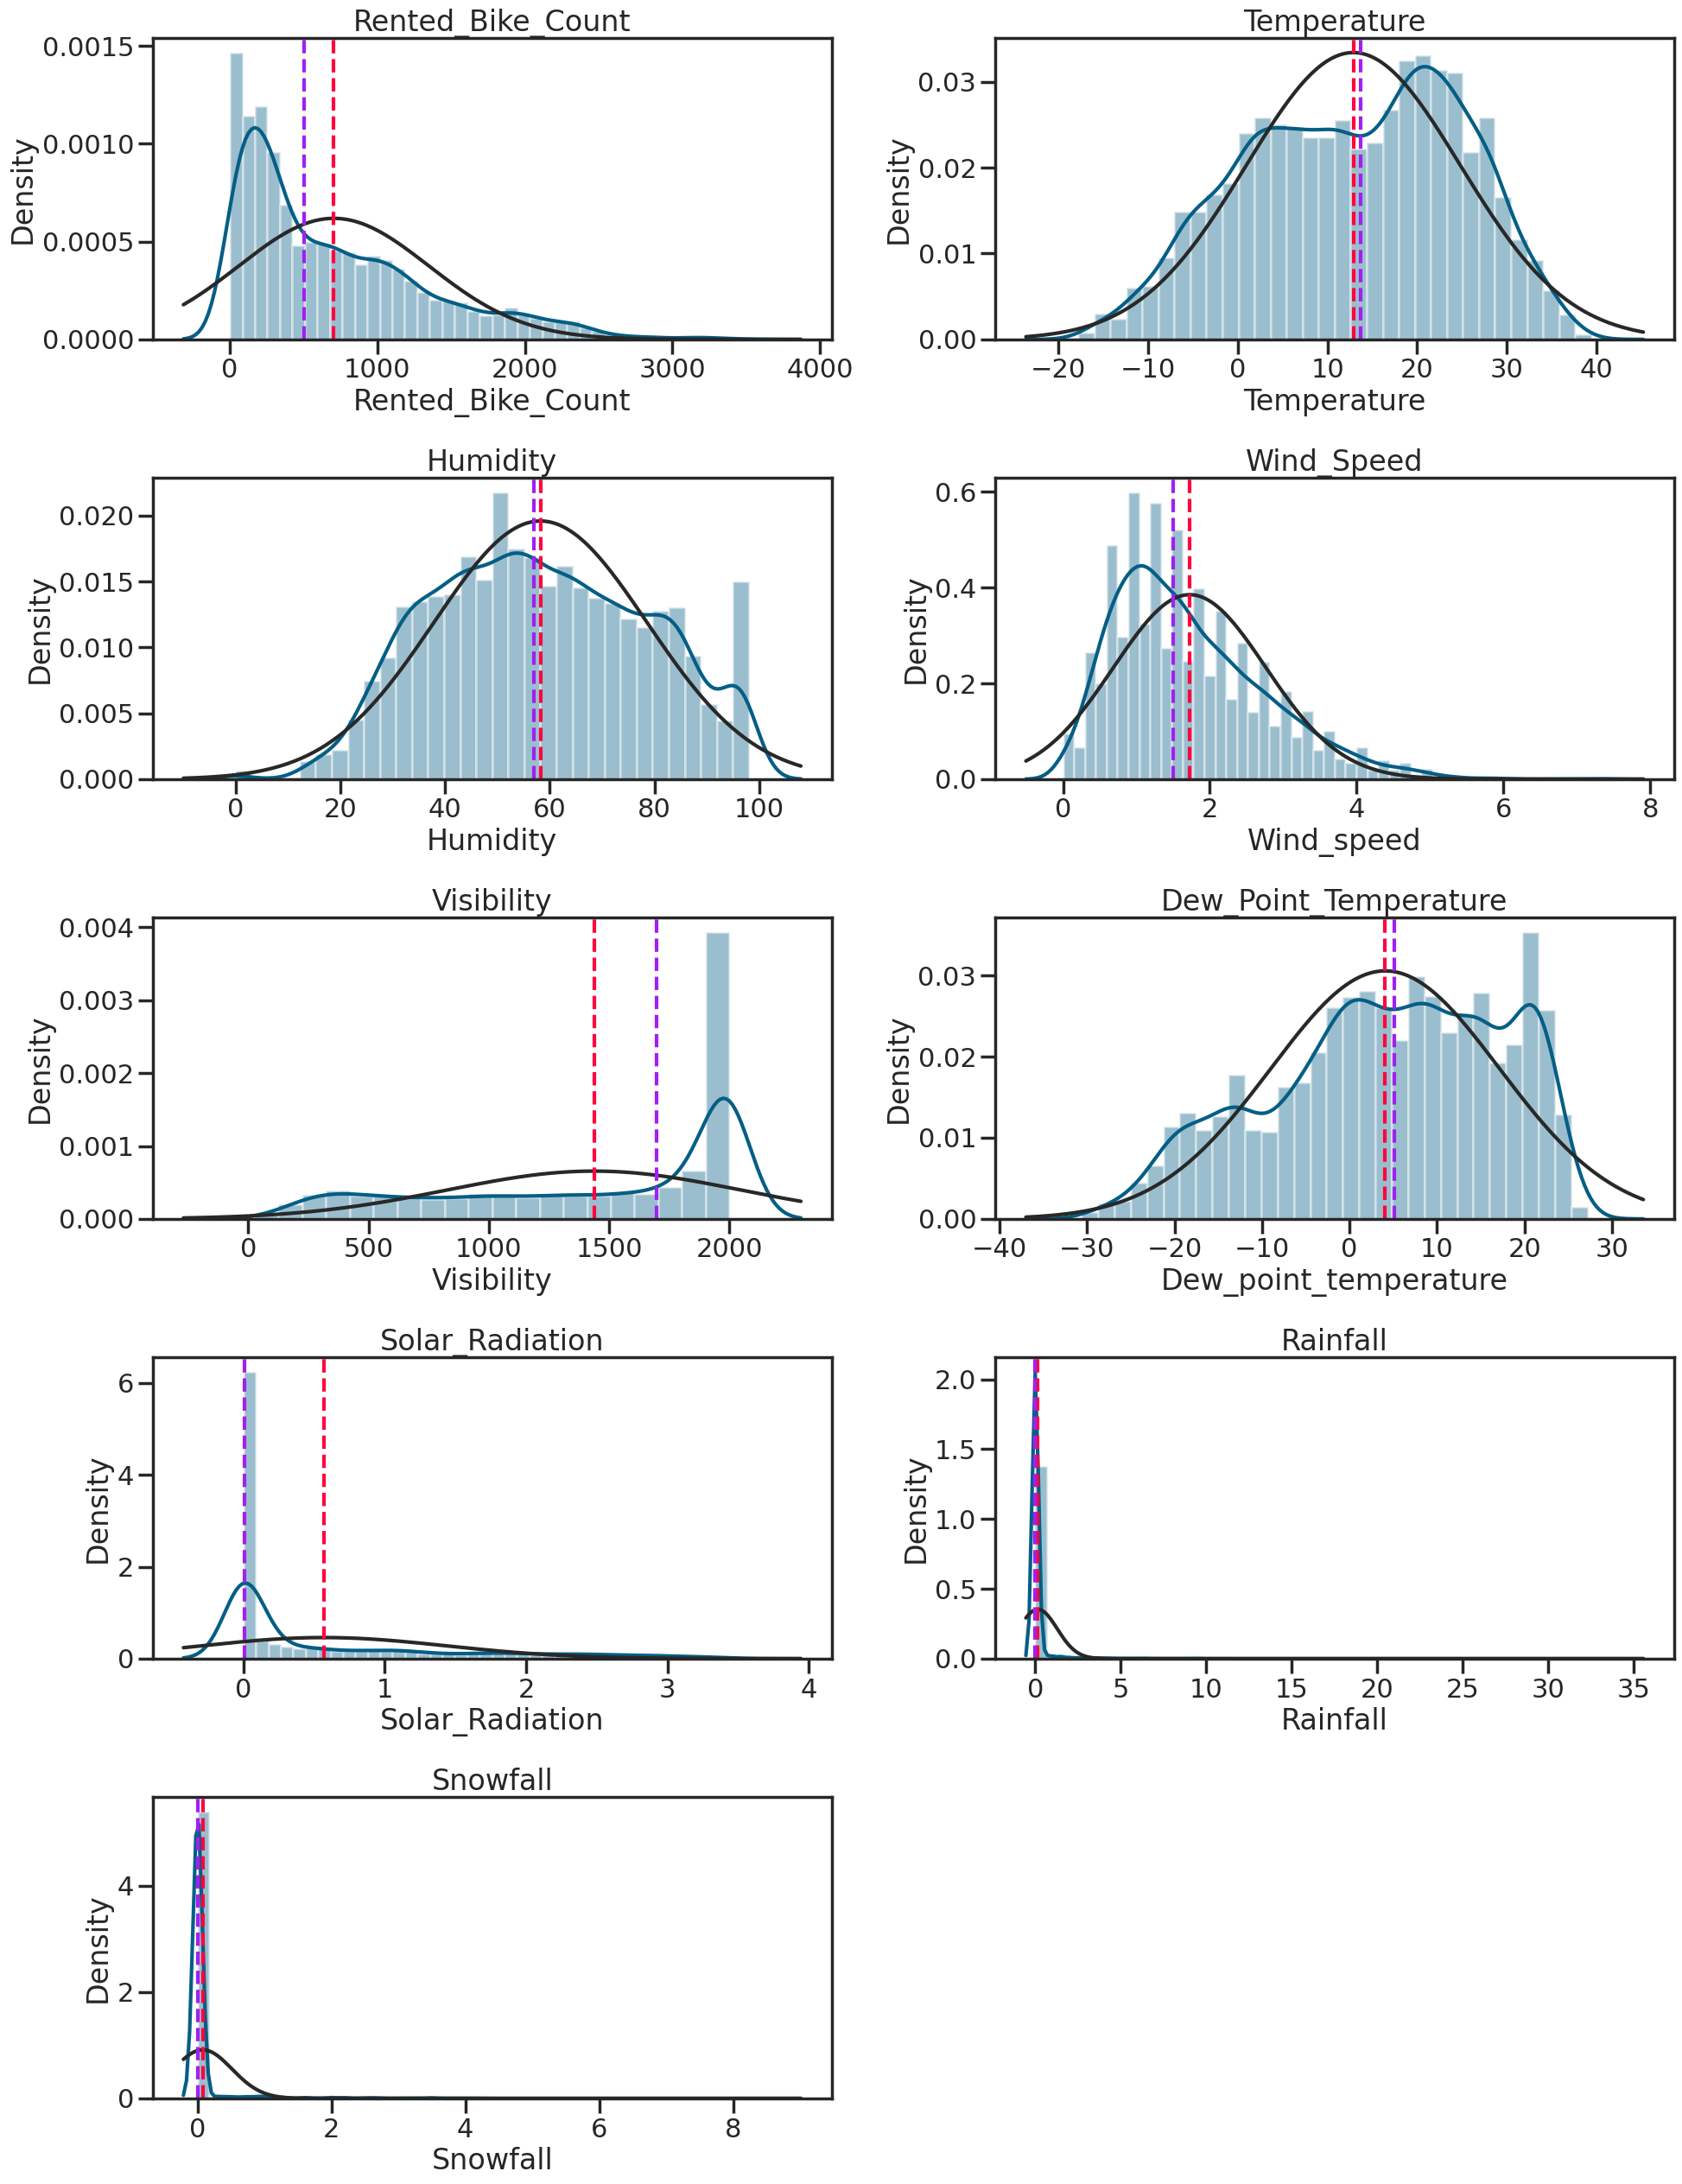

In [26]:
density_plot(dfr,num_feature)

<Figure size 1500x600 with 0 Axes>

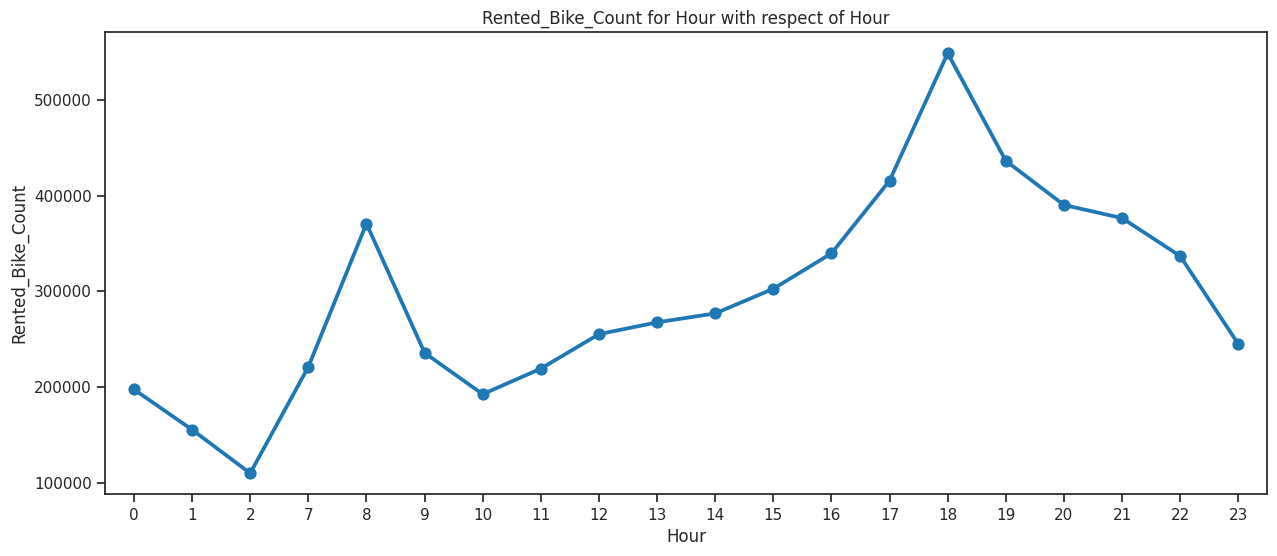

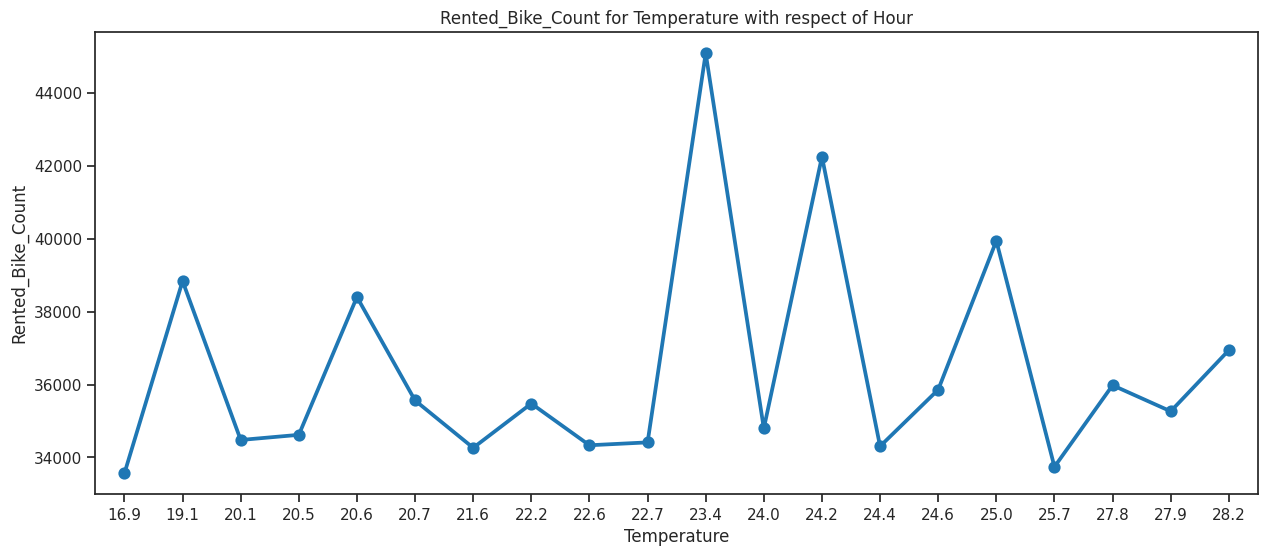

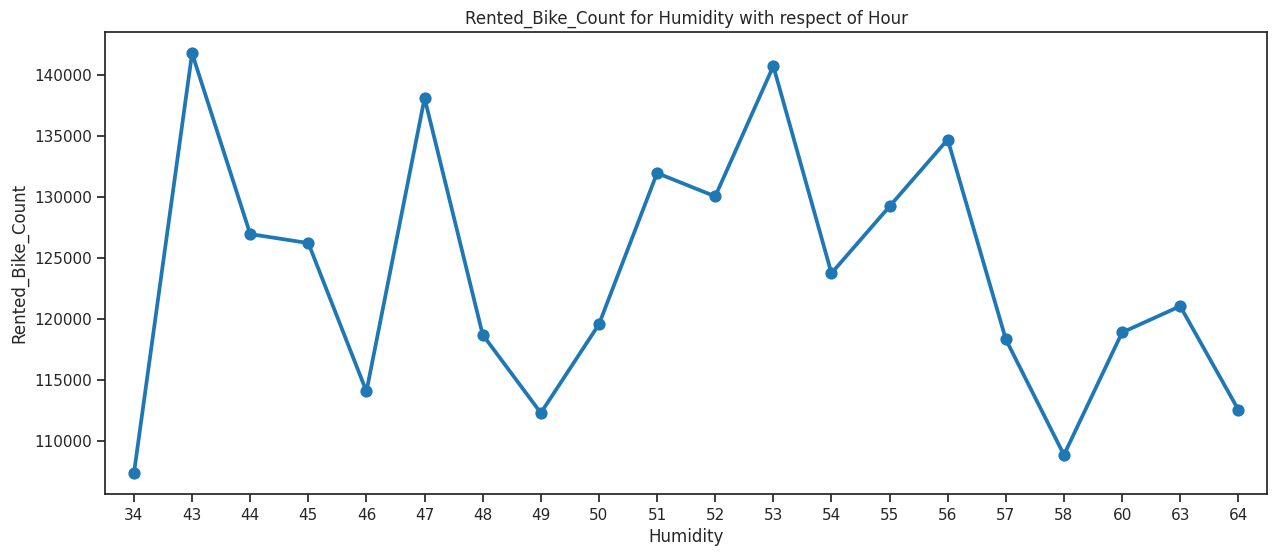

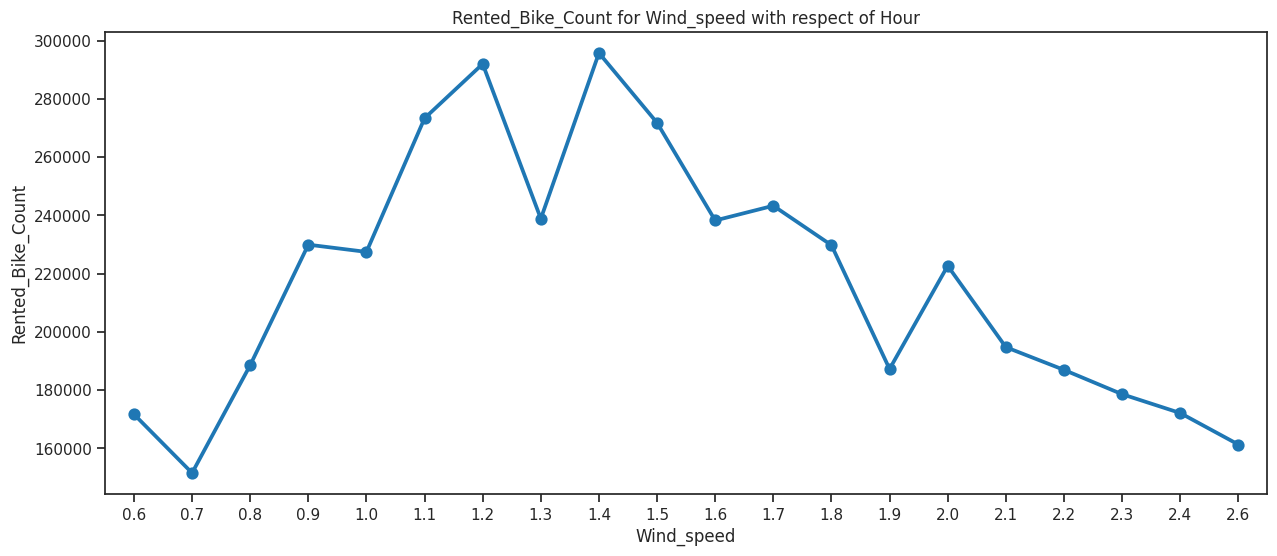

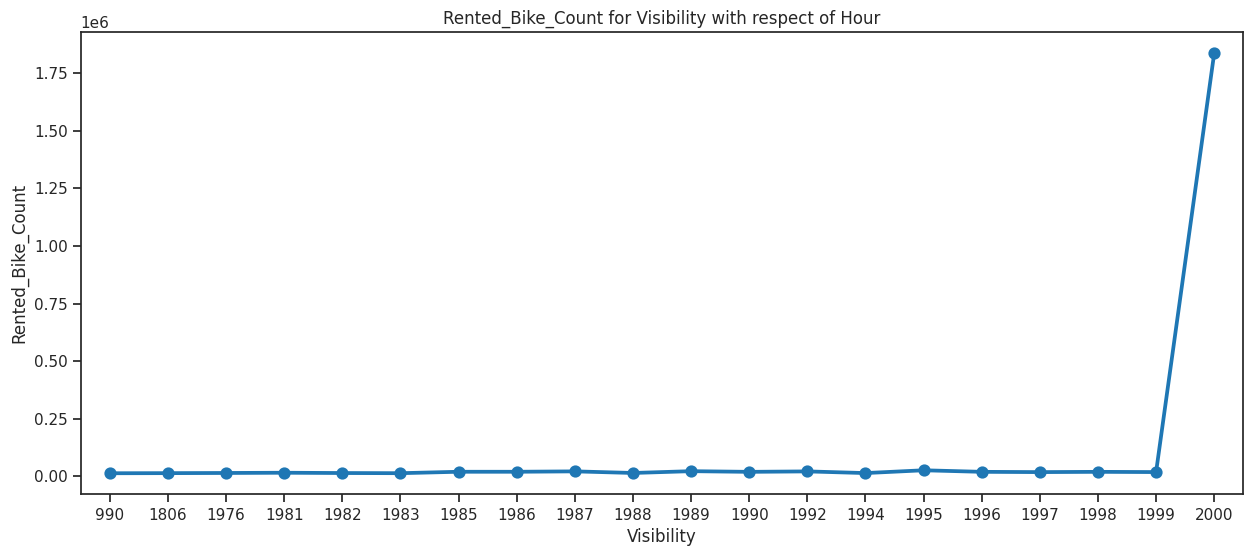

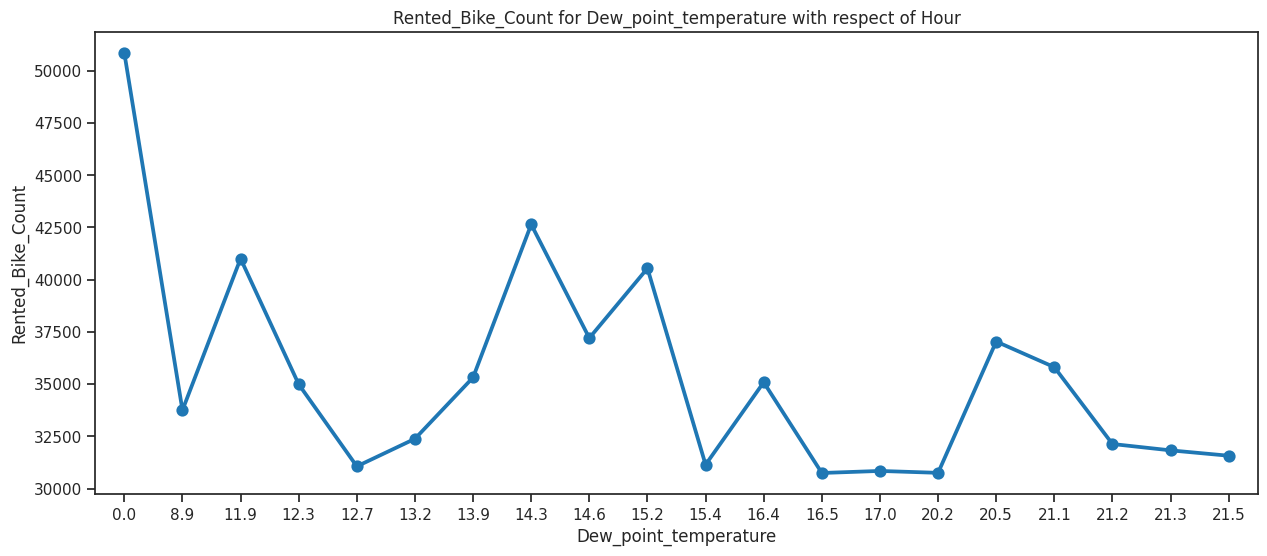

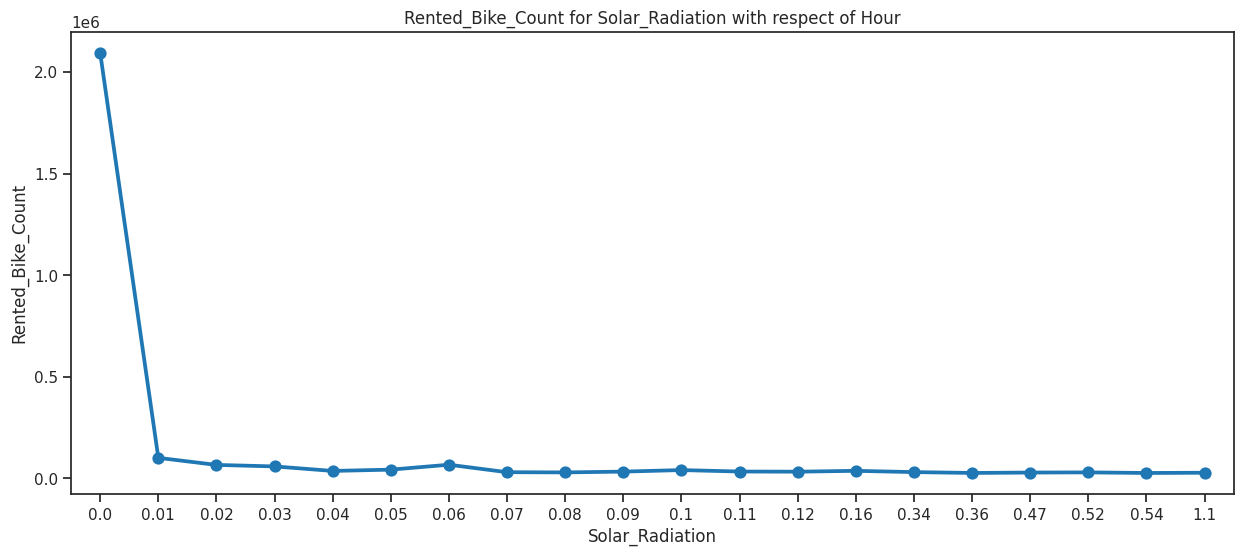

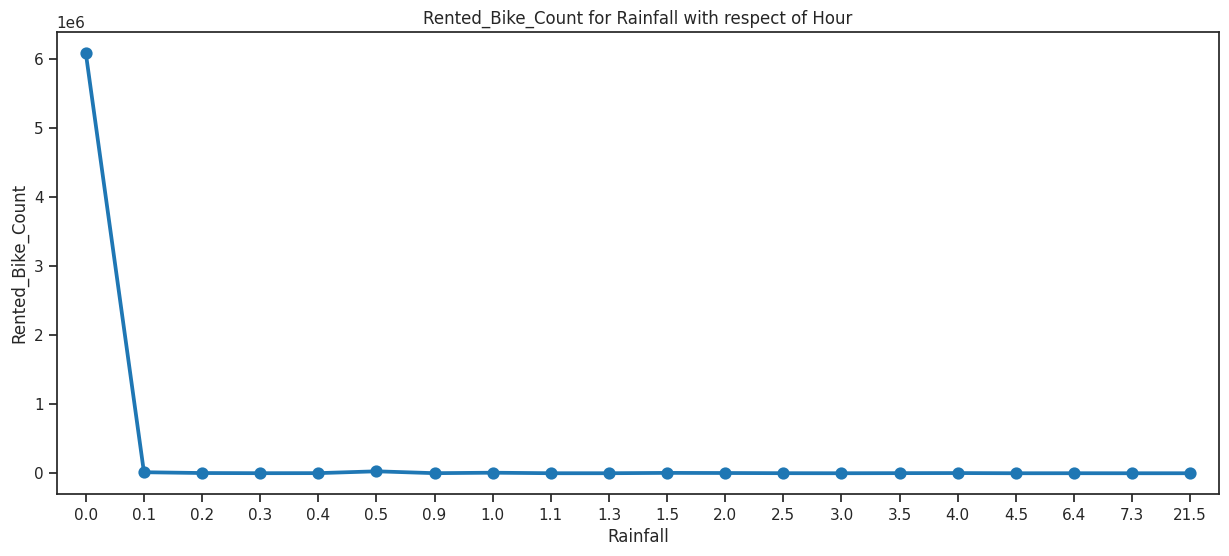

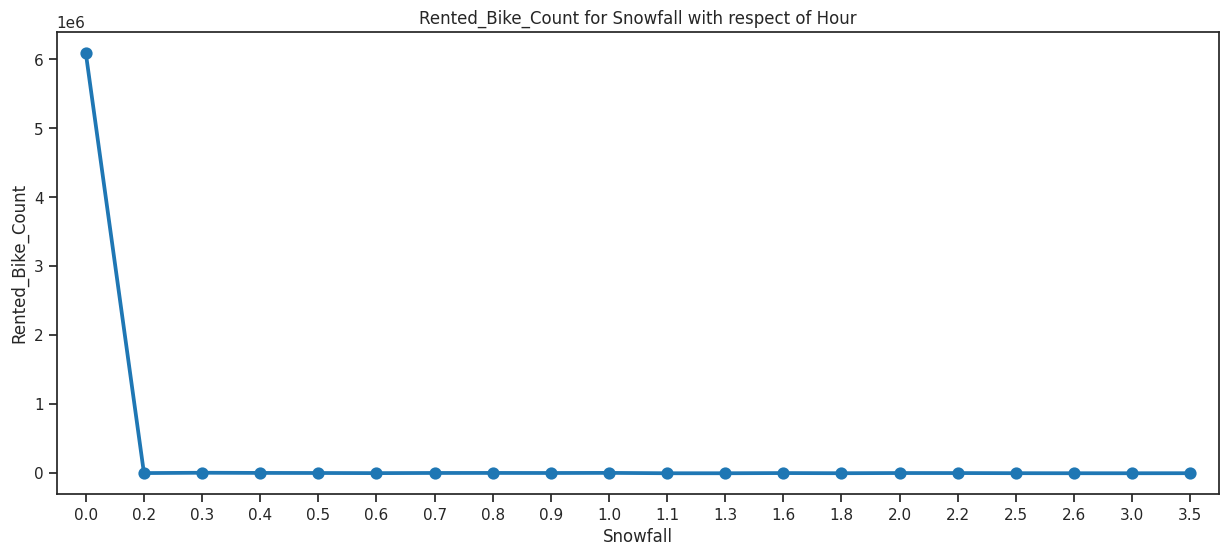

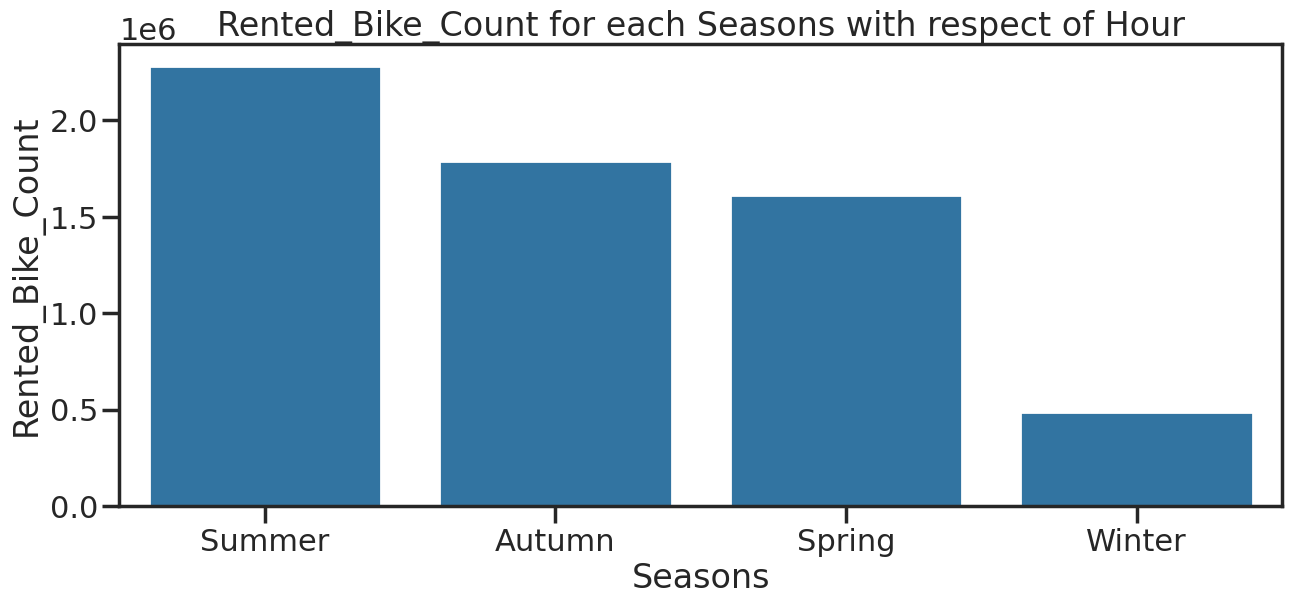

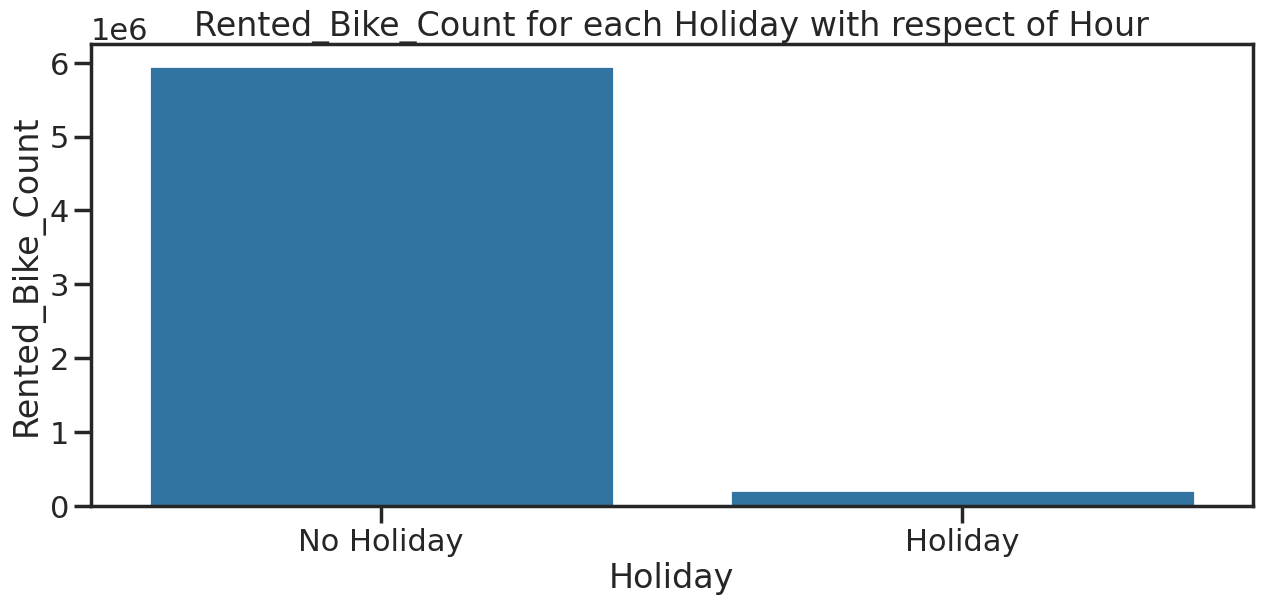

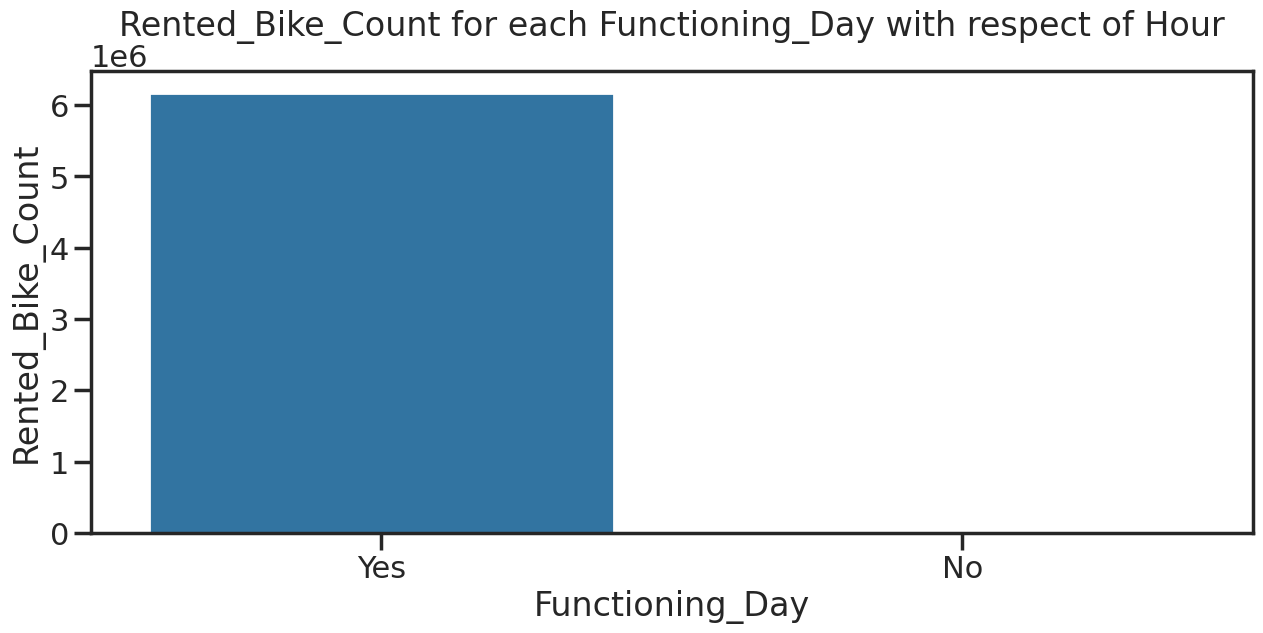

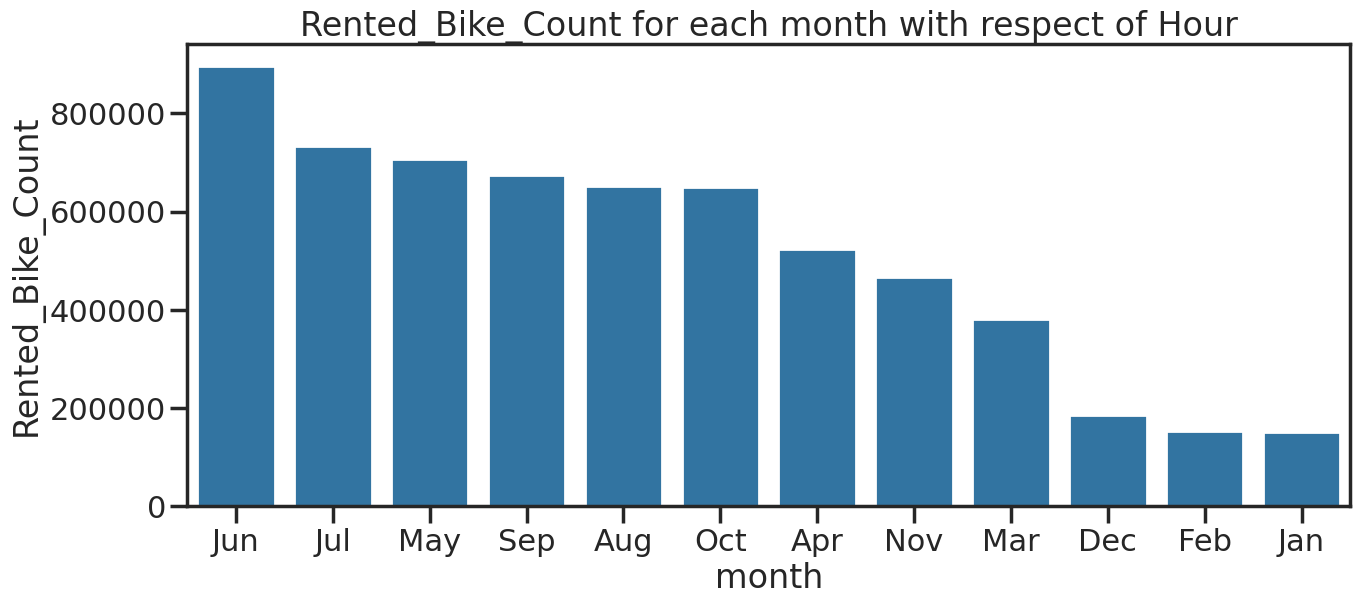

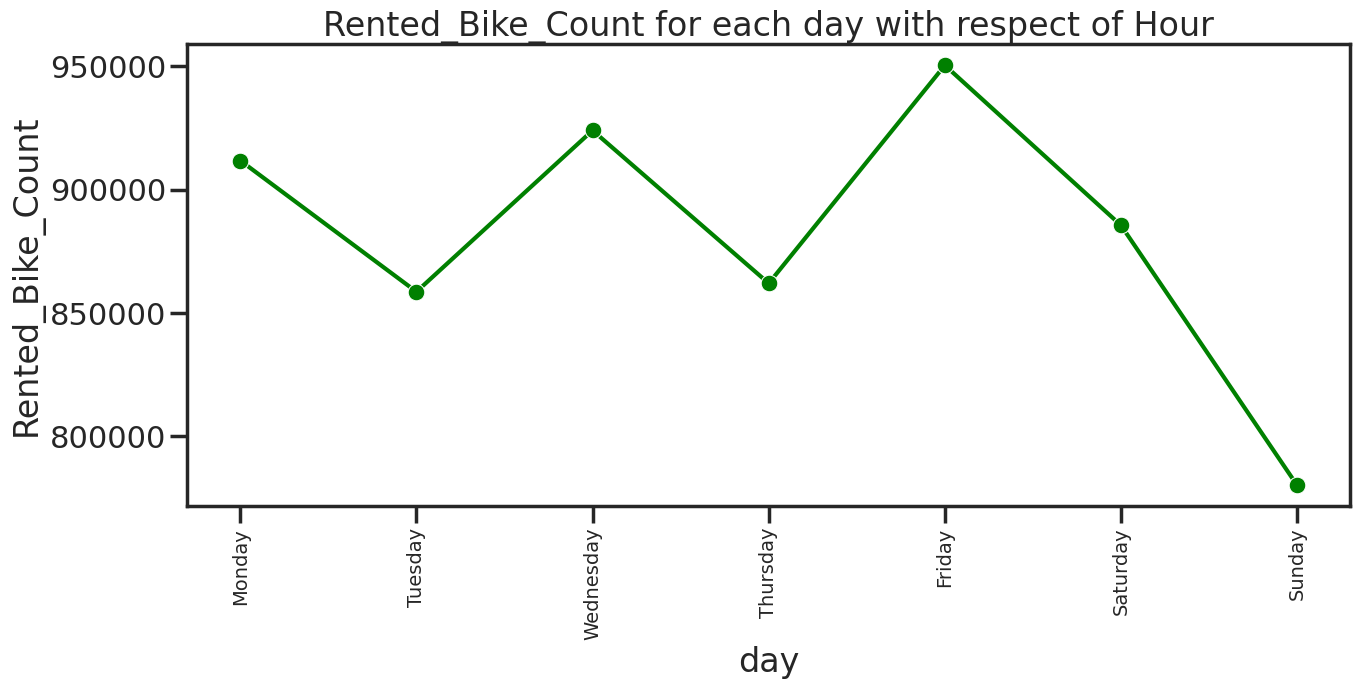

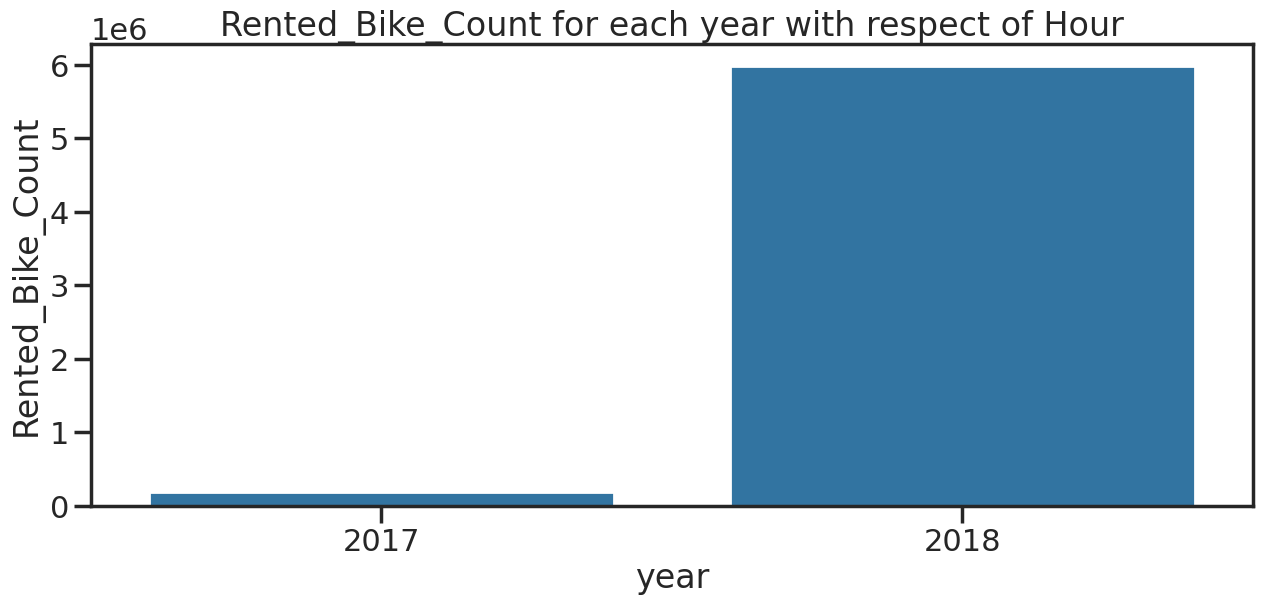

In [28]:
for i in dfr.columns:
  plt.figure(figsize=(15,6))
  if i == 'Rented_Bike_Count':
    pass
  elif i in ['Seasons','Holiday','Functioning_Day','month','year']:
    grp = dfr.groupby([i], as_index = False)['Rented_Bike_Count'].sum().sort_values('Rented_Bike_Count',
                                                                                    ascending = False)
    sns.set_context('poster');
    sns.barplot(x=grp[i], y=grp["Rented_Bike_Count"]);
    plt.title(f"Rented_Bike_Count for each {i} with respect of Hour");
    print('\n')
  elif i == 'day':
    workingdays = {'day':['Monday','Tuesday','Wednesday','Thursday','Friday',	'Saturday',	'Sunday']}
    workingday = pd.DataFrame(workingdays)
    grp = dfr.groupby([i], as_index = False)['Rented_Bike_Count'].sum().sort_values('Rented_Bike_Count',
                                                                                    ascending = False)
    chart = workingday.merge(grp)
    sns.set_context('poster');
    sns.lineplot(data= chart, x=chart[i],y= chart['Rented_Bike_Count'], marker= 'o', color = 'green');
    plt.xticks(fontsize = 14, rotation = 90);
    plt.title(f"Rented_Bike_Count for each {i} with respect of Hour");
  else :
    grp = dfr.groupby([i], as_index = False)['Rented_Bike_Count'].sum().sort_values('Rented_Bike_Count',
                                                                                    ascending = False).head(20)
    sns.set_context('notebook');
    sns.pointplot(x=grp[i], y=grp["Rented_Bike_Count"]);
    plt.title(f"Rented_Bike_Count for {i} with respect of Hour");
    print('\n')

  plt.show()

In [29]:
def group_by(df,feature):
  data = df.groupby([feature], as_index = False)['Rented_Bike_Count'].sum().sort_values('Rented_Bike_Count', ascending = False)
  return data

In [30]:
group_by(dfr,'Functioning_Day')

,Functioning_Day,Rented_Bike_Count
1,Yes,6172314
0,No,0


In [31]:
group_by(dfr,'Holiday')

,Holiday,Rented_Bike_Count
1,No Holiday,5956419
0,Holiday,215895


In [32]:
group_by(dfr,'year')

,year,Rented_Bike_Count
1,2018,5986984
0,2017,185330


In [33]:
group_by(dfr,'Seasons')

,Seasons,Rented_Bike_Count
2,Summer,2283234
0,Autumn,1790002
1,Spring,1611909
3,Winter,487169


In [34]:
weekend = group_by(dfr,'day')
chutti = weekend[(weekend['day'] == 'Saturday') | (weekend['day'] == 'Sunday')]
chutti

,day,Rented_Bike_Count
2,Saturday,885492
3,Sunday,780194


In [35]:
workingday = group_by(dfr,'day')
office = workingday[(workingday['day'] != 'Saturday') & (workingday['day'] != 'Sunday')]
office

,day,Rented_Bike_Count
0,Friday,950334
6,Wednesday,923956
1,Monday,911743
4,Thursday,861999
5,Tuesday,858596


In [36]:
d = office['Rented_Bike_Count'].sum() > chutti['Rented_Bike_Count'].sum()
print(f' Is it true that bike rented count is more on working day? {d}')

 Is it true that bike rented count is more on working day? True


In [37]:
copy_for_future = dfr.copy()
trial = dfr.copy()

In [38]:
trial['Functioning_Day']= LabelEncoder().fit_transform(trial['Functioning_Day'])

In [39]:
trial['Functioning_Day'].value_counts()

,count
Functioning_Day,
1,8465
0,295


In [40]:
corr = trial[['Rented_Bike_Count','Functioning_Day']].corr()
corr

,Rented_Bike_Count,Functioning_Day
Rented_Bike_Count,1.000,0.204
Functioning_Day,0.204,1.000


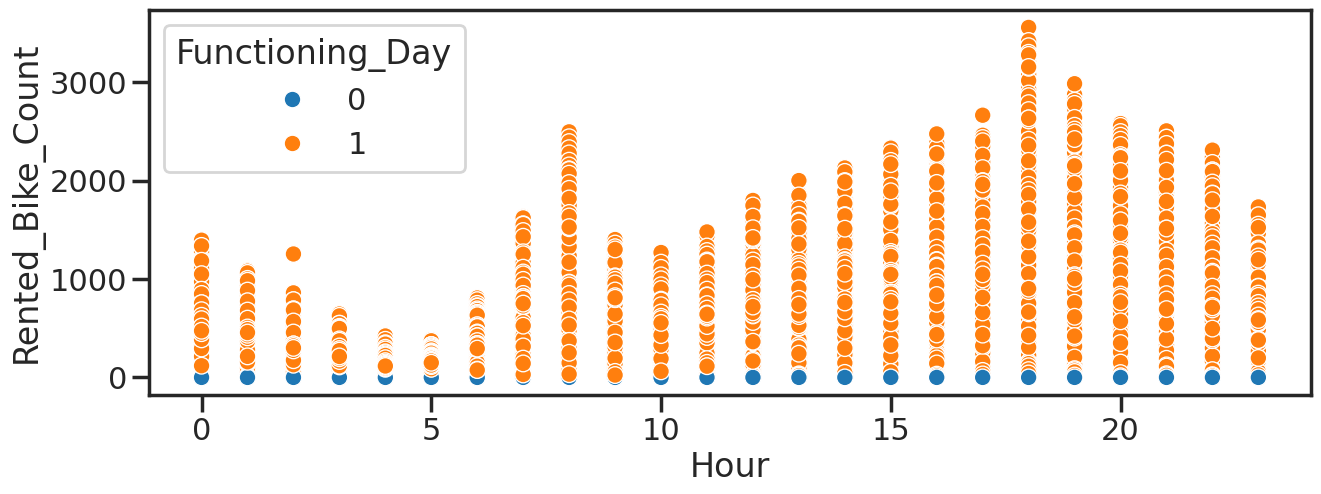

In [41]:
plt.figure(figsize = (15,5));
sns.scatterplot(data = trial[['Rented_Bike_Count','Hour','Functioning_Day']], x = trial['Hour'], y = trial['Rented_Bike_Count'], hue = trial['Functioning_Day']);

In [42]:
value = dfr.drop(dfr[dfr['Functioning_Day'] == 'No'].index)

In [43]:
value['Functioning_Day'].value_counts()

,count
Functioning_Day,
Yes,8465


In [44]:
value = value.drop(['Functioning_Day'], axis = 1)
value.shape

(8465, 15)

In [45]:
print(f'Shape of original data: {copy_for_future.shape}')
print(f'Shape of new data : {value.shape}')

Shape of original data: (8760, 16)
Shape of new data : (8465, 15)


In [46]:
value['week'] = value['day'].apply(lambda x:'Weekend'  if x=='Saturday' or  x== 'Sunday' else 'workingdays')

In [47]:
value.week.value_counts()

,count
week,
workingdays,6024
Weekend,2441


# **Encoding Categorial Variable**

In [58]:
values = value.drop(columns=['day'], axis = 1)

In [59]:
values = values.drop(columns =['year'], axis = 1)

In [60]:
values = values.drop(columns=['Dew_point_temperature'], axis = 1)

In [61]:
num = values.select_dtypes(exclude ='object')
cat = values.select_dtypes(include ='object')
print(f' numeric: {num.columns.to_list()}\n categorial : {cat.columns.to_list()}')

 numeric: ['Rented_Bike_Count', 'Temperature', 'Humidity', 'Wind_speed', 'Visibility', 'Solar_Radiation', 'Rainfall', 'Snowfall']
 categorial : ['Hour', 'Seasons', 'Holiday', 'month', 'week']


In [62]:
encoded = values.apply(LabelEncoder().fit_transform)
encoded.head(1)

,Rented_Bike_Count,Hour,Temperature,Humidity,Wind_speed,Visibility,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,month,week
0,252,0,111,28,22,1779,0,0,0,3,1,2,1


In [63]:
dumcoded = pd.get_dummies(values,drop_first=True,sparse=True)
dumcoded.head(1)

,Rented_Bike_Count,Temperature,Humidity,Wind_speed,Visibility,Solar_Radiation,Rainfall,Snowfall,Hour_1,Hour_2,...,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,week_workingdays
0,254,-5.200,37,2.200,2000,0.000,0.000,0.000,False,False,...,False,False,False,False,False,False,False,False,False,True


* When encoded using dummies, column size is increased to 47. Therefore, using label encoded values in futher process, however there is no issue in using get_dummies but sometime it may led to [dummy variable trap](https://www.geeksforgeeks.org/ml-dummy-variable-trap-in-regression-models/) which can again cause multicollinearity.

#**Gausssian Transformation**

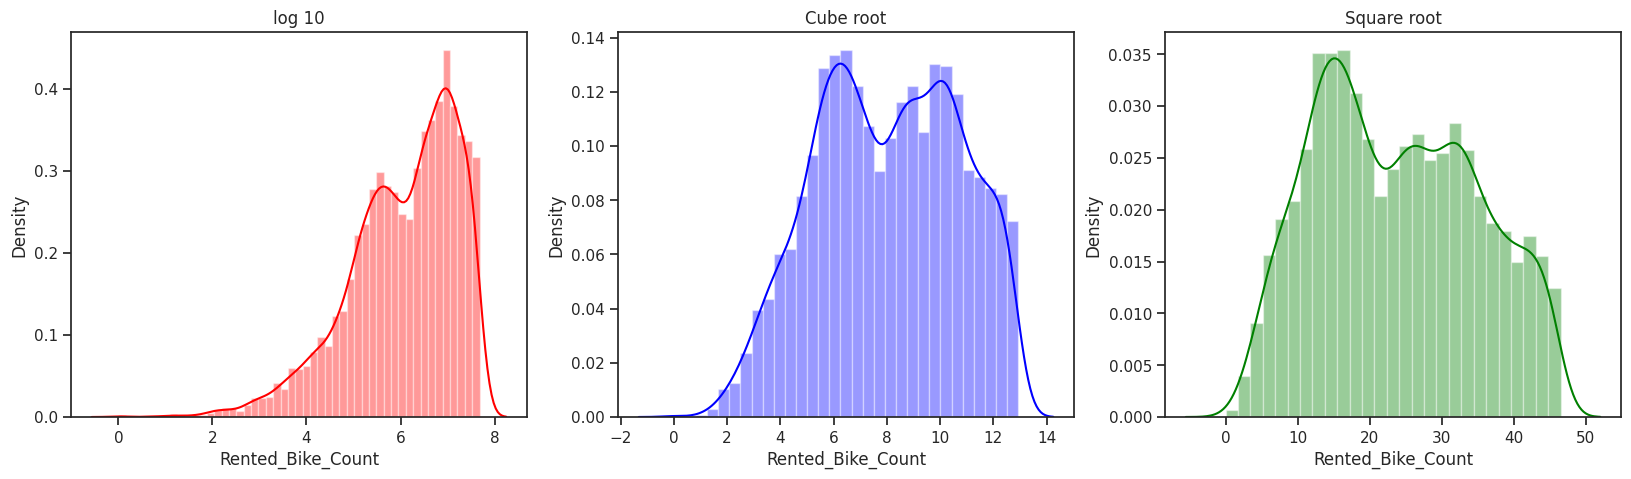

In [64]:
fig,axes = plt.subplots(1,3,figsize=(20,5))
sns.distplot(np.log1p(encoded['Rented_Bike_Count']),ax=axes[0],color='red').set_title("log 10");
sns.distplot(np.cbrt(encoded['Rented_Bike_Count']),ax=axes[1],color='blue').set_title("Cube root");
sns.distplot(np.sqrt(encoded['Rented_Bike_Count']),ax=axes[2], color='green').set_title("Square root");

In [65]:
encoded['Rented_Bike_Count']=np.sqrt(encoded['Rented_Bike_Count'])

#**Model Training**

In [66]:
X=encoded.drop('Rented_Bike_Count',axis=1)
y=encoded['Rented_Bike_Count']

In [67]:
X.head(1)

,Hour,Temperature,Humidity,Wind_speed,Visibility,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,month,week
0,0,111,28,22,1779,0,0,0,3,1,2,1


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 7)

In [69]:
print(f'Shape of X_train => {X_train.shape}, Shape of X_test => {X_test.shape}' )
print(f'Shape of y_train => {y_train.shape}, Shape of y_test => {y_test.shape}' )

Shape of X_train => (6348, 12), Shape of X_test => (2117, 12)
Shape of y_train => (6348,), Shape of y_test => (2117,)


In [70]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [71]:
model1 = [
          ['Linear Regression ', LinearRegression()],
           ['Lasso ', Lasso(alpha =0.1 , max_iter= 2000)],
           ['Ridge ', Ridge(alpha =0.1 , max_iter= 2000)],
           ['KNeighborsRegressor ',  neighbors.KNeighborsRegressor()],
           ['RandomForest ',RandomForestRegressor(criterion='absolute_error',random_state=42)]
        ]

    ====================  Linear Regression  ====================


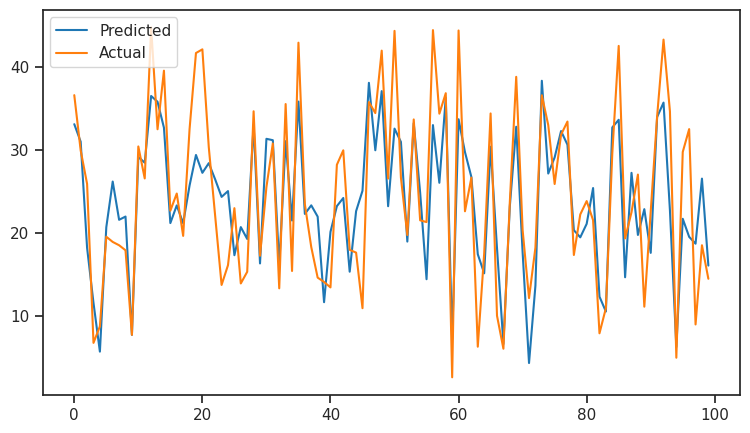

    ====================  Lasso  ====================


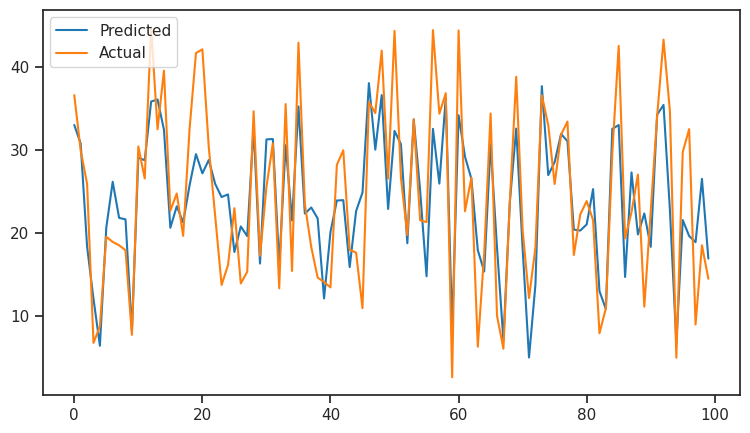

    ====================  Ridge  ====================


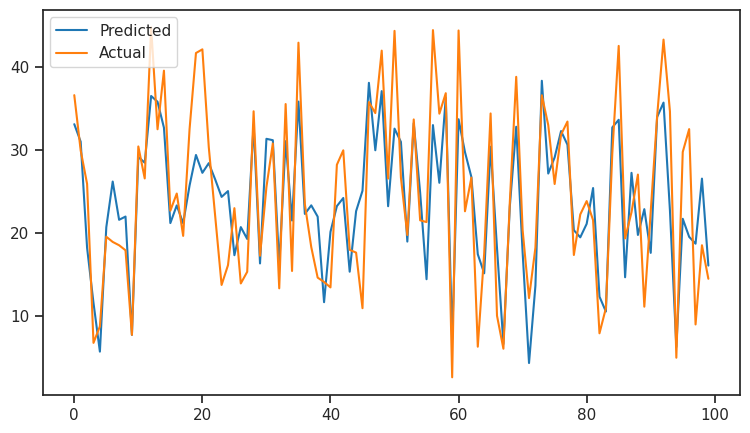

    ====================  KNeighborsRegressor  ====================


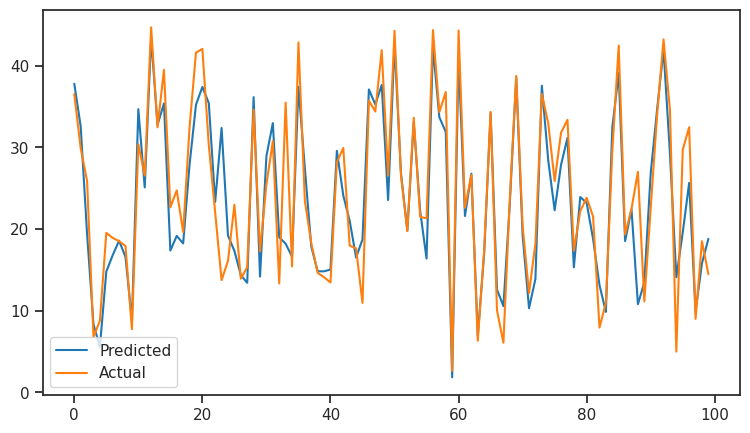

    ====================  RandomForest  ====================


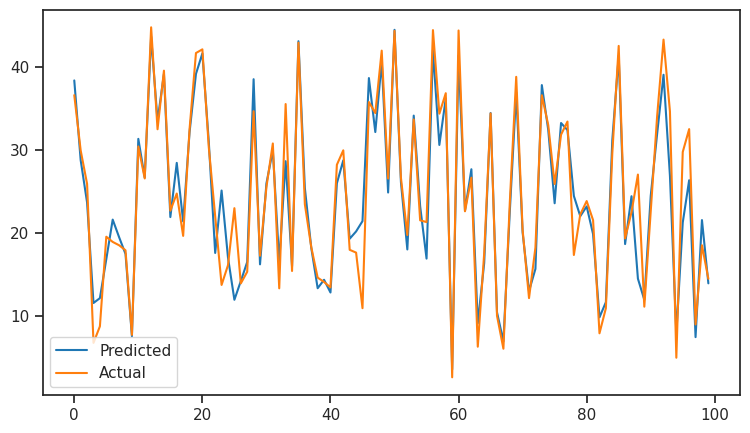

In [72]:
model_score = []
for name,model in model1 :
    model_data = {}
    model_data["Name"] = name
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    model_data["MSE"] = mse(y_test, y_pred)
    model_data["RMSE"] = np.sqrt(model_data["MSE"])
    model_data["R2_Score"] = r2(y_test, y_pred)
    model_data["ADJ_R2"] = 1-(1-r2(y_test, y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
    print(f'    {20* "="}  {name} {20* "="}')
    plt.figure(figsize=(9,5))
    plt.plot((y_pred)[:100])
    plt.plot((np.array(y_test)[:100]))
    plt.legend(["Predicted","Actual"])
    plt.show()
    model_score.append(model_data)

In [73]:
model1_df = pd.DataFrame(model_score)
model1_df

,Name,MSE,RMSE,R2_Score,ADJ_R2
0,Linear Regression,41.671,6.455,0.660,0.658
1,Lasso,41.713,6.459,0.659,0.657
2,Ridge,41.671,6.455,0.660,0.658
3,KNeighborsRegressor,21.818,4.671,0.822,0.821
4,RandomForest,8.859,2.976,0.928,0.927


In [74]:
model1_df.sort_values(by=['R2_Score'], ascending = False)

,Name,MSE,RMSE,R2_Score,ADJ_R2
4,RandomForest,8.859,2.976,0.928,0.927
3,KNeighborsRegressor,21.818,4.671,0.822,0.821
0,Linear Regression,41.671,6.455,0.660,0.658
2,Ridge,41.671,6.455,0.660,0.658
1,Lasso,41.713,6.459,0.659,0.657


In [75]:
model2 = [
           ['GradientBoostingRegressor ', GradientBoostingRegressor(n_estimators=400, max_depth=4)] ,
           ['Light-GBM ', lightgbm.LGBMRegressor(num_leaves=41, n_estimators=400,random_state=42)],
           ['XGBRegressor ', XGBRegressor(objective= 'reg:squarederror')]
]

    ====================  GradientBoostingRegressor  ====================


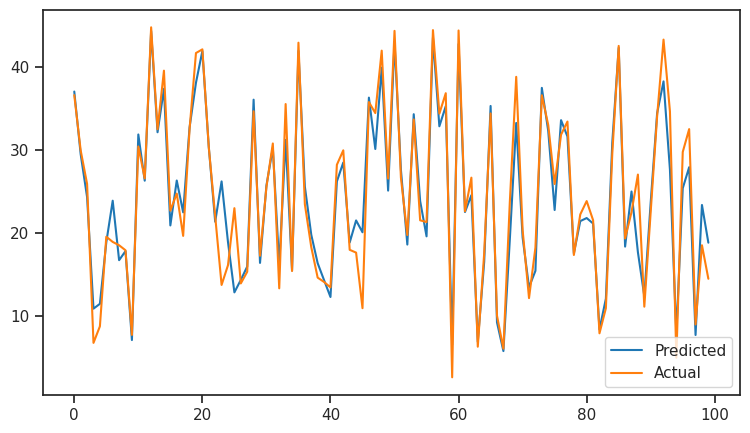

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1012
[LightGBM] [Info] Number of data points in the train set: 6348, number of used features: 12
[LightGBM] [Info] Start training from score 23.752765
    ====================  Light-GBM  ====================


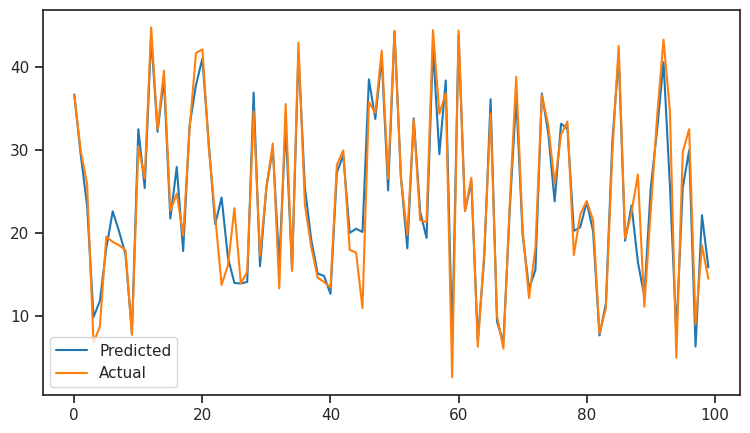

    ====================  XGBRegressor  ====================


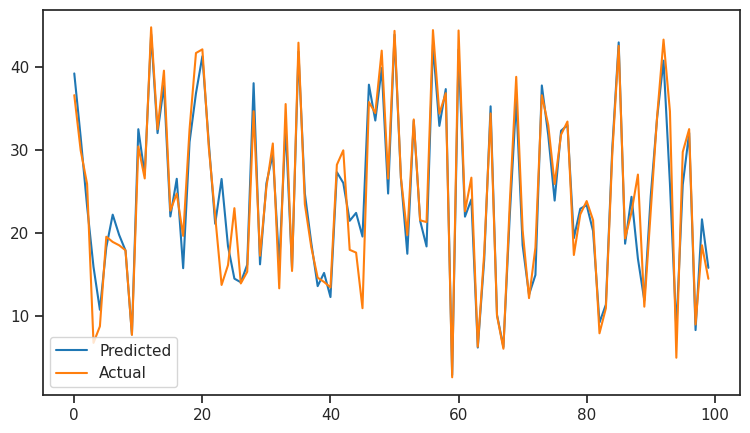

In [76]:
model_score2 = []
for name,model in model2 :
    model_data = {}
    model_data["Name"] = name
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    model_data["MSE"] = mse(y_test, y_pred)
    model_data["RMSE"] = np.sqrt(model_data["MSE"])
    model_data["R2_Score"] = r2(y_test, y_pred)
    model_data["ADJ_R2"] = 1-(1-r2(y_test,y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
    print(f'    {20* "="}  {name} {20* "="}')
    plt.figure(figsize=(9,5))
    plt.plot((y_pred)[:100])
    plt.plot((np.array(y_test)[:100]))
    plt.legend(["Predicted","Actual"])
    plt.show()
    model_score2.append(model_data)

In [77]:
model2_df = pd.DataFrame(model_score2)
model2_df

,Name,MSE,RMSE,R2_Score,ADJ_R2
0,GradientBoostingRegressor,7.311,2.704,0.940,0.940
1,Light-GBM,6.452,2.540,0.947,0.947
2,XGBRegressor,7.150,2.674,0.942,0.941


In [78]:
a= [model1_df,model2_df]
final = pd.concat(a,ignore_index=True)
final.sort_values('R2_Score', ascending =False)

,Name,MSE,RMSE,R2_Score,ADJ_R2
6,Light-GBM,6.452,2.540,0.947,0.947
7,XGBRegressor,7.150,2.674,0.942,0.941
5,GradientBoostingRegressor,7.311,2.704,0.940,0.940
4,RandomForest,8.859,2.976,0.928,0.927
3,KNeighborsRegressor,21.818,4.671,0.822,0.821
0,Linear Regression,41.671,6.455,0.660,0.658
2,Ridge,41.671,6.455,0.660,0.658
1,Lasso,41.713,6.459,0.659,0.657


In [79]:
model = XGBRegressor(objective= 'reg:squarederror',subsample=0.7)

In [80]:
params = {
     'gamma' : [ -0.5, 0, 0.5, 1],
    'learning_rate' :[0.001, 0.01, 0.1, 5,10 ],
    'n_estimators' : [25,50,75,100,500] ,
    'max_depth' : [3, 5, 7,10]
        }

In [81]:
gridsearch = GridSearchCV(model , params , cv=2 , return_train_score=True)

In [82]:
gridsearch.fit(X_train , y_train )

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'gamma': [-0.5, 0, 0.5, 1],
                         'learning_rate': [0.001, 0.01, 0.1, 5, 10],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [25, 50, 75, 100, 500]},
             return_train_score=True)

In [83]:
print(gridsearch.best_params_)

{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}


In [84]:
gridsearch_predictions = gridsearch.predict( X_test )

In [85]:
XGBRegressor_with_hyper = {
'Name': "XGBRegressor_with_hyper",
'MSE': [mse(y_test,gridsearch.predict(X_test))],
'RMSE': [np.sqrt(mse(y_test,gridsearch.predict(X_test)))],
'R2_Score': [r2(y_test,gridsearch_predictions)],
'ADJ_R2': [1-(1-r2(y_test,y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))],
}

In [86]:
Result = pd.DataFrame.from_dict(XGBRegressor_with_hyper)

b = [final,Result]
final_df = pd.concat(b,ignore_index=True)
final_df.sort_values('R2_Score', ascending =False)

,Name,MSE,RMSE,R2_Score,ADJ_R2
6,Light-GBM,6.452,2.540,0.947,0.947
8,XGBRegressor_with_hyper,6.466,2.543,0.947,0.941
7,XGBRegressor,7.150,2.674,0.942,0.941
5,GradientBoostingRegressor,7.311,2.704,0.940,0.940
4,RandomForest,8.859,2.976,0.928,0.927
3,KNeighborsRegressor,21.818,4.671,0.822,0.821
0,Linear Regression,41.671,6.455,0.660,0.658
2,Ridge,41.671,6.455,0.660,0.658
1,Lasso,41.713,6.459,0.659,0.657


In [87]:
y_pred_XGB = gridsearch.predict( X_test )

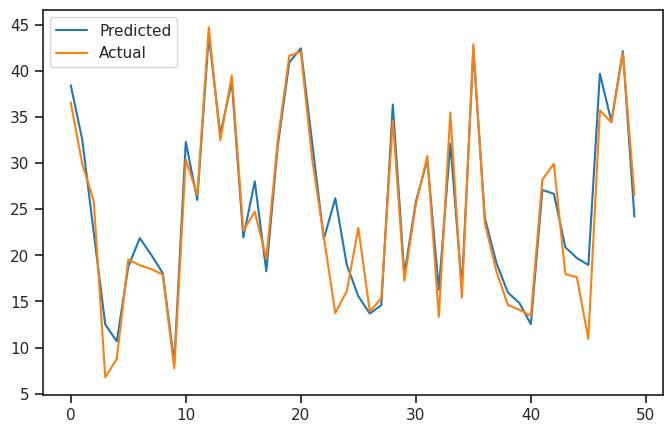

In [88]:
plt.figure(figsize=(8,5))
plt.plot((y_pred_XGB)[:50])
plt.plot((np.array(y_test))[:50])
plt.legend(["Predicted","Actual"])
plt.show()

In [89]:
pd.DataFrame(zip(y_test, y_pred_XGB, (y_test - y_pred_XGB)), columns = ['actual', 'predicted', 'Difference(act-pre)'])[:10]

,actual,predicted,Difference(act-pre)
0,36.565,38.439,-1.874
1,29.917,32.554,-2.637
2,25.904,22.454,3.449
3,6.782,12.503,-5.721
4,8.775,10.679,-1.904
5,19.545,18.757,0.788
6,18.921,21.874,-2.953
7,18.520,20.056,-1.536
8,17.916,18.077,-0.160
9,7.746,8.382,-0.636


In [90]:
rf_optimal_model = gridsearch.best_estimator_

In [91]:
rf_optimal_model.feature_importances_

array([0.16509227, 0.147083  , 0.09520619, 0.00829535, 0.00830744,
       0.02334405, 0.1874066 , 0.02281013, 0.13465966, 0.06515049,
       0.05730166, 0.08534311], dtype=float32)

In [92]:
t = pd.DataFrame(X_train, columns = X.columns)

In [93]:
importances = rf_optimal_model.feature_importances_

importance_dict = {'Feature' : list(t.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [94]:
importance_df.sort_values(by=['Feature Importance'],ascending=False)

,Feature,Feature Importance
6,Rainfall,0.187
0,Hour,0.165
1,Temperature,0.147
8,Seasons,0.135
2,Humidity,0.095
11,week,0.085
9,Holiday,0.065
10,month,0.057
5,Solar_Radiation,0.023
7,Snowfall,0.023


In [95]:
fig = px.pie(importance_df, values='Feature Importance', names='Feature', title='Feature Importance');

fig.update_traces(textposition='inside', textinfo='percent+label');
fig.show();